**Gabriela Sandanieli de Aguiar (11913509) - Engenharia de Computação - USP São Carlos**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Pré-processamento das imagens**

In [ ]:
# Instala as bibliotecas necessárias para o processamento das imagens
!pip install nibabel opencv-python tqdm

In [ ]:
# Importa bibliotecas essenciais
import os                    # Para manipulação de arquivos e diretórios
import numpy as np           # Para manipulações numéricas
import nibabel as nib        # Para leitura de arquivos NIfTI (.nii/.nii.gz)
import cv2                   # OpenCV para processamento de imagem
from tqdm import tqdm        # Barra de progresso para loops

In [ ]:
def normalize(img):
    # Converte para float32 para evitar problemas com divisões inteiras
    img = img.astype(np.float32)

    # Normaliza os valores entre 0 e 1, depois escala para 0-255
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    return (img * 255).astype(np.uint8)

In [ ]:
def resize_and_pad(img, size=256):
    h, w = img.shape  # Altura e largura originais
    scale = size / max(h, w)  # Escala baseada na maior dimensão
    resized = cv2.resize(img, (int(w * scale), int(h * scale)))  # Redimensiona mantendo proporção

    # Calcula quanto de padding adicionar em cada lado
    h_pad = (size - resized.shape[0]) // 2
    w_pad = (size - resized.shape[1]) // 2

    # Aplica padding com bordas pretas (valor 0)
    padded = cv2.copyMakeBorder(resized, h_pad, size - resized.shape[0] - h_pad,
                                w_pad, size - resized.shape[1] - w_pad,
                                cv2.BORDER_CONSTANT, value=0)
    return padded

In [ ]:
def save_slices(patient_id, flair_nii, mask_nii=None, num_slices=20):
    flair_data = nib.load(flair_nii).get_fdata()  # Carrega volume FLAIR
    flair_data = np.transpose(flair_data, (2, 0, 1))  # Reorganiza eixos: (slices, altura, largura)

    if mask_nii:
        mask_data = nib.load(mask_nii).get_fdata()
        mask_data = np.transpose(mask_data, (2, 0, 1))
    else:
        mask_data = np.zeros_like(flair_data)  # Se não houver máscara, usa zeros

    # Define diretórios de saída
    output_patient_dir = os.path.join(output_dir, patient_id)
    flair_out = os.path.join(output_patient_dir, "flair")
    mask_out = os.path.join(output_patient_dir, "mask")

    os.makedirs(flair_out, exist_ok=True)
    if np.sum(mask_data) > 0:
        os.makedirs(mask_out, exist_ok=True)

    # Seleciona slices com lesões (se houver máscara), ou 20 centrais (se não houver)
    if mask_nii and np.sum(mask_data) > 0:
        valid_slices = [i for i in range(mask_data.shape[0]) if np.sum(mask_data[i]) > 0]
        selected_slices = sorted(valid_slices)
        print(f"[INFO] {patient_id}: {len(selected_slices)} slices com lesão salvas.")
    else:
        center = flair_data.shape[0] // 2
        half = num_slices // 2
        selected_slices = list(range(center - half, center + half))
        print(f"[INFO] {patient_id}: 20 slices centrais salvas (saudável).")

    # Processa e salva cada slice
    for idx, slice_idx in enumerate(selected_slices):
        flair_slice = normalize(flair_data[slice_idx])
        mask_slice = normalize(mask_data[slice_idx]) if mask_nii else np.zeros_like(flair_slice)

        # Rotaciona para padronizar orientação
        flair_slice = cv2.rotate(flair_slice, cv2.ROTATE_90_COUNTERCLOCKWISE)
        mask_slice = cv2.rotate(mask_slice, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Redimensiona com padding
        flair_slice = resize_and_pad(flair_slice, size=256)
        mask_slice = resize_and_pad(mask_slice, size=256)

        # Gera nomes dos arquivos
        flair_name = f"{patient_id}-slice-{idx+1:02}.png"
        mask_name = f"{patient_id}-mask-{idx+1:02}.png"

        # Salva as imagens
        cv2.imwrite(os.path.join(flair_out, flair_name), flair_slice)
        if mask_nii and np.sum(mask_data) > 0:
            cv2.imwrite(os.path.join(mask_out, mask_name), mask_slice)

In [ ]:
input_dir = "/content/drive/MyDrive/TCC"
output_dir = "/content/drive/MyDrive/TCC/slices_subs"
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Processa os pacientes
sub_dirs = sorted([d for d in os.listdir(input_dir) if d.startswith("sub-")])
print(f"Encontrados {len(sub_dirs)} pacientes.")

for sub in tqdm(sub_dirs):
    anat_dir = os.path.join(input_dir, sub, "anat")
    if not os.path.exists(anat_dir):
        continue

    flair_file = None
    mask_file = None

    # Identifica os arquivos FLAIR e ROI (máscara)
    for file in os.listdir(anat_dir):
        if file.endswith("_FLAIR.nii.gz") and "roi" not in file:
            flair_file = os.path.join(anat_dir, file)
        elif file.endswith("_FLAIR_roi.nii.gz"):
            mask_file = os.path.join(anat_dir, file)

    if flair_file is None:
        print(f"[ERRO] FLAIR não encontrado para {sub}, pulando.")
        continue

    if mask_file and not os.path.exists(mask_file):
        print(f"[AVISO] Máscara esperada mas não encontrada para {sub}.")
        mask_file = None

    # Executa o salvamento dos slices
    save_slices(sub, flair_file, mask_file)

Encontrados 170 pacientes.


  0%|          | 0/170 [00:00<?, ?it/s]

[INFO] sub-00001: 19 slices com lesão salvas.


  1%|          | 1/170 [00:05<14:47,  5.25s/it]

[INFO] sub-00002: 20 slices centrais salvas (saudável).


  1%|          | 2/170 [00:08<10:47,  3.85s/it]

[INFO] sub-00003: 40 slices com lesão salvas.


  2%|▏         | 3/170 [00:13<12:36,  4.53s/it]

[INFO] sub-00004: 16 slices com lesão salvas.


  3%|▎         | 5/170 [00:18<08:54,  3.24s/it]

[INFO] sub-00005: 20 slices centrais salvas (saudável).
[INFO] sub-00006: 9 slices com lesão salvas.


  4%|▎         | 6/170 [00:21<08:51,  3.24s/it]

[INFO] sub-00007: 20 slices centrais salvas (saudável).


  4%|▍         | 7/170 [00:23<07:50,  2.88s/it]

[INFO] sub-00008: 20 slices centrais salvas (saudável).


  5%|▍         | 8/170 [00:25<06:54,  2.56s/it]

[INFO] sub-00009: 11 slices com lesão salvas.


  5%|▌         | 9/170 [00:29<07:38,  2.84s/it]

[INFO] sub-00010: 38 slices com lesão salvas.


  6%|▌         | 10/170 [00:32<08:19,  3.12s/it]

[INFO] sub-00011: 20 slices centrais salvas (saudável).


  6%|▋         | 11/170 [00:35<07:40,  2.90s/it]

[INFO] sub-00012: 20 slices centrais salvas (saudável).


  7%|▋         | 12/170 [00:38<07:31,  2.86s/it]

[INFO] sub-00013: 20 slices centrais salvas (saudável).


  8%|▊         | 13/170 [00:40<06:44,  2.58s/it]

[INFO] sub-00014: 19 slices com lesão salvas.


  8%|▊         | 14/170 [00:43<07:26,  2.86s/it]

[INFO] sub-00015: 24 slices com lesão salvas.


  9%|▉         | 15/170 [00:47<08:00,  3.10s/it]

[INFO] sub-00016: 49 slices com lesão salvas.


  9%|▉         | 16/170 [00:51<08:44,  3.41s/it]

[INFO] sub-00017: 20 slices centrais salvas (saudável).


 11%|█         | 18/170 [00:56<07:45,  3.06s/it]

[INFO] sub-00018: 6 slices com lesão salvas.
[INFO] sub-00019: 20 slices centrais salvas (saudável).


 11%|█         | 19/170 [00:59<07:20,  2.91s/it]

[INFO] sub-00020: 34 slices com lesão salvas.


 12%|█▏        | 20/170 [01:03<08:08,  3.26s/it]

[INFO] sub-00021: 20 slices centrais salvas (saudável).


 13%|█▎        | 22/170 [01:08<06:45,  2.74s/it]

[INFO] sub-00022: 20 slices centrais salvas (saudável).
[INFO] sub-00023: 20 slices centrais salvas (saudável).


 14%|█▎        | 23/170 [01:10<06:21,  2.60s/it]

[INFO] sub-00024: 12 slices com lesão salvas.


 14%|█▍        | 24/170 [01:13<06:49,  2.81s/it]

[INFO] sub-00025: 20 slices centrais salvas (saudável).


 15%|█▍        | 25/170 [01:16<06:52,  2.85s/it]

[INFO] sub-00026: 20 slices centrais salvas (saudável).


 15%|█▌        | 26/170 [01:19<06:51,  2.86s/it]

[INFO] sub-00027: 11 slices com lesão salvas.


 16%|█▋        | 28/170 [01:26<07:58,  3.37s/it]

[INFO] sub-00028: 20 slices centrais salvas (saudável).
[INFO] sub-00029: 20 slices centrais salvas (saudável).


 17%|█▋        | 29/170 [01:29<07:21,  3.13s/it]

[INFO] sub-00030: 20 slices centrais salvas (saudável).


 18%|█▊        | 31/170 [01:33<06:13,  2.69s/it]

[INFO] sub-00031: 20 slices centrais salvas (saudável).
[INFO] sub-00032: 26 slices com lesão salvas.


 19%|█▉        | 32/170 [01:37<06:49,  2.97s/it]

[INFO] sub-00033: 16 slices com lesão salvas.


 19%|█▉        | 33/170 [01:41<07:23,  3.23s/it]

[INFO] sub-00034: 12 slices com lesão salvas.


 20%|██        | 34/170 [01:44<07:30,  3.31s/it]

[INFO] sub-00035: 20 slices centrais salvas (saudável).


 21%|██        | 36/170 [01:49<06:23,  2.86s/it]

[INFO] sub-00036: 20 slices centrais salvas (saudável).
[INFO] sub-00037: 20 slices centrais salvas (saudável).


 22%|██▏       | 37/170 [01:52<06:11,  2.79s/it]

[INFO] sub-00038: 31 slices com lesão salvas.


 23%|██▎       | 39/170 [01:59<06:54,  3.17s/it]

[INFO] sub-00039: 20 slices centrais salvas (saudável).
[INFO] sub-00040: 42 slices com lesão salvas.


 24%|██▍       | 41/170 [02:06<06:56,  3.23s/it]

[INFO] sub-00041: 20 slices centrais salvas (saudável).
[INFO] sub-00042: 20 slices centrais salvas (saudável).


 25%|██▍       | 42/170 [02:08<06:11,  2.90s/it]

[INFO] sub-00043: 21 slices com lesão salvas.


 25%|██▌       | 43/170 [02:13<07:12,  3.40s/it]

[INFO] sub-00044: 16 slices com lesão salvas.


 26%|██▋       | 45/170 [02:19<06:47,  3.26s/it]

[INFO] sub-00045: 20 slices centrais salvas (saudável).
[INFO] sub-00046: 20 slices centrais salvas (saudável).


 27%|██▋       | 46/170 [02:22<06:24,  3.10s/it]

[INFO] sub-00047: 32 slices com lesão salvas.


 28%|██▊       | 47/170 [02:26<06:57,  3.40s/it]

[INFO] sub-00048: 16 slices com lesão salvas.


 28%|██▊       | 48/170 [02:29<06:44,  3.32s/it]

[INFO] sub-00049: 20 slices centrais salvas (saudável).


 29%|██▉       | 49/170 [02:31<05:51,  2.90s/it]

[INFO] sub-00050: 21 slices com lesão salvas.


 29%|██▉       | 50/170 [02:34<06:03,  3.03s/it]

[INFO] sub-00051: 20 slices centrais salvas (saudável).


 30%|███       | 51/170 [02:36<05:23,  2.72s/it]

[INFO] sub-00052: 20 slices centrais salvas (saudável).


 31%|███       | 53/170 [02:41<05:09,  2.64s/it]

[INFO] sub-00053: 3 slices com lesão salvas.
[INFO] sub-00054: 20 slices centrais salvas (saudável).


 32%|███▏      | 54/170 [02:44<05:01,  2.60s/it]

[INFO] sub-00055: 48 slices com lesão salvas.


 33%|███▎      | 56/170 [02:50<05:20,  2.81s/it]

[INFO] sub-00056: 20 slices centrais salvas (saudável).
[INFO] sub-00057: 20 slices centrais salvas (saudável).


 34%|███▎      | 57/170 [02:52<04:44,  2.52s/it]

[INFO] sub-00058: 40 slices com lesão salvas.


 34%|███▍      | 58/170 [02:56<05:36,  3.01s/it]

[INFO] sub-00059: 29 slices com lesão salvas.


 35%|███▍      | 59/170 [03:00<06:03,  3.28s/it]

[INFO] sub-00060: 32 slices com lesão salvas.


 35%|███▌      | 60/170 [03:04<06:16,  3.42s/it]

[INFO] sub-00061: 31 slices com lesão salvas.


 36%|███▌      | 61/170 [03:08<06:23,  3.51s/it]

[INFO] sub-00062: 16 slices com lesão salvas.


 36%|███▋      | 62/170 [03:11<06:02,  3.36s/it]

[INFO] sub-00063: 49 slices com lesão salvas.


 37%|███▋      | 63/170 [03:15<06:31,  3.66s/it]

[INFO] sub-00064: 55 slices com lesão salvas.


 38%|███▊      | 64/170 [03:19<06:29,  3.67s/it]

[INFO] sub-00065: 10 slices com lesão salvas.


 38%|███▊      | 65/170 [03:21<05:55,  3.39s/it]

[INFO] sub-00066: 27 slices com lesão salvas.


 39%|███▉      | 67/170 [03:27<05:13,  3.04s/it]

[INFO] sub-00067: 20 slices centrais salvas (saudável).
[INFO] sub-00068: 25 slices com lesão salvas.


 40%|████      | 68/170 [03:31<05:31,  3.25s/it]

[INFO] sub-00069: 20 slices centrais salvas (saudável).


 41%|████      | 69/170 [03:33<04:55,  2.92s/it]

[INFO] sub-00070: 20 slices centrais salvas (saudável).


 41%|████      | 70/170 [03:36<05:06,  3.07s/it]

[INFO] sub-00071: 20 slices com lesão salvas.


 42%|████▏     | 71/170 [03:40<05:11,  3.14s/it]

[INFO] sub-00072: 12 slices com lesão salvas.


 42%|████▏     | 72/170 [03:43<05:08,  3.15s/it]

[INFO] sub-00073: 14 slices com lesão salvas.


 44%|████▎     | 74/170 [03:49<04:49,  3.02s/it]

[INFO] sub-00074: 3 slices com lesão salvas.
[INFO] sub-00075: 20 slices centrais salvas (saudável).


 44%|████▍     | 75/170 [03:53<05:10,  3.27s/it]

[INFO] sub-00076: 15 slices com lesão salvas.


 45%|████▍     | 76/170 [03:55<04:56,  3.15s/it]

[INFO] sub-00077: 28 slices com lesão salvas.


 45%|████▌     | 77/170 [03:59<05:06,  3.30s/it]

[INFO] sub-00078: 27 slices com lesão salvas.


 46%|████▋     | 79/170 [04:05<04:40,  3.08s/it]

[INFO] sub-00079: 20 slices centrais salvas (saudável).
[INFO] sub-00080: 18 slices com lesão salvas.


 47%|████▋     | 80/170 [04:09<04:47,  3.19s/it]

[INFO] sub-00081: 13 slices com lesão salvas.


 48%|████▊     | 81/170 [04:12<04:51,  3.27s/it]

[INFO] sub-00082: 20 slices centrais salvas (saudável).


 48%|████▊     | 82/170 [04:15<04:43,  3.22s/it]

[INFO] sub-00083: 13 slices com lesão salvas.


 49%|████▉     | 83/170 [04:18<04:31,  3.12s/it]

[INFO] sub-00084: 20 slices centrais salvas (saudável).


 49%|████▉     | 84/170 [04:20<03:59,  2.79s/it]

[INFO] sub-00085: 20 slices centrais salvas (saudável).


 50%|█████     | 85/170 [04:22<03:40,  2.60s/it]

[INFO] sub-00086: 20 slices centrais salvas (saudável).


 51%|█████     | 86/170 [04:24<03:29,  2.50s/it]

[INFO] sub-00087: 16 slices com lesão salvas.


 51%|█████     | 87/170 [04:28<03:50,  2.78s/it]

[INFO] sub-00088: 20 slices centrais salvas (saudável).


 52%|█████▏    | 88/170 [04:31<03:50,  2.81s/it]

[INFO] sub-00089: 18 slices com lesão salvas.


 52%|█████▏    | 89/170 [04:34<03:58,  2.95s/it]

[INFO] sub-00090: 34 slices com lesão salvas.


 53%|█████▎    | 90/170 [04:37<04:04,  3.05s/it]

[INFO] sub-00091: 12 slices com lesão salvas.


 54%|█████▎    | 91/170 [04:40<03:58,  3.02s/it]

[INFO] sub-00092: 24 slices com lesão salvas.


 54%|█████▍    | 92/170 [04:43<04:00,  3.08s/it]

[INFO] sub-00093: 20 slices centrais salvas (saudável).


 55%|█████▍    | 93/170 [04:46<03:34,  2.79s/it]

[INFO] sub-00094: 20 slices centrais salvas (saudável).


 55%|█████▌    | 94/170 [04:48<03:16,  2.59s/it]

[INFO] sub-00095: 20 slices com lesão salvas.


 56%|█████▋    | 96/170 [04:53<03:16,  2.65s/it]

[INFO] sub-00096: 20 slices centrais salvas (saudável).
[INFO] sub-00097: 23 slices com lesão salvas.


 57%|█████▋    | 97/170 [04:57<03:28,  2.85s/it]

[INFO] sub-00098: 24 slices com lesão salvas.


 58%|█████▊    | 98/170 [05:00<03:45,  3.13s/it]

[INFO] sub-00099: 15 slices com lesão salvas.


 58%|█████▊    | 99/170 [05:04<03:47,  3.20s/it]

[INFO] sub-00100: 25 slices com lesão salvas.


 59%|█████▉    | 100/170 [05:08<03:57,  3.39s/it]

[INFO] sub-00101: 19 slices com lesão salvas.


 60%|██████    | 102/170 [05:13<03:23,  2.99s/it]

[INFO] sub-00102: 20 slices centrais salvas (saudável).
[INFO] sub-00103: 23 slices com lesão salvas.


 61%|██████    | 104/170 [05:18<02:58,  2.70s/it]

[INFO] sub-00104: 20 slices centrais salvas (saudável).
[INFO] sub-00105: 17 slices com lesão salvas.


 62%|██████▏   | 105/170 [05:21<03:05,  2.85s/it]

[INFO] sub-00106: 20 slices centrais salvas (saudável).


 62%|██████▏   | 106/170 [05:24<03:01,  2.84s/it]

[INFO] sub-00107: 27 slices com lesão salvas.


 63%|██████▎   | 107/170 [05:28<03:11,  3.04s/it]

[INFO] sub-00108: 14 slices com lesão salvas.


 64%|██████▎   | 108/170 [05:31<03:12,  3.10s/it]

[INFO] sub-00109: 28 slices com lesão salvas.


 64%|██████▍   | 109/170 [05:34<03:16,  3.22s/it]

[INFO] sub-00110: 20 slices centrais salvas (saudável).


 65%|██████▍   | 110/170 [05:37<03:04,  3.07s/it]

[INFO] sub-00111: 20 slices centrais salvas (saudável).


 66%|██████▌   | 112/170 [05:43<02:59,  3.10s/it]

[INFO] sub-00112: 4 slices com lesão salvas.


 66%|██████▋   | 113/170 [05:45<02:37,  2.77s/it]

[INFO] sub-00113: 20 slices centrais salvas (saudável).


 67%|██████▋   | 114/170 [05:48<02:37,  2.81s/it]

[INFO] sub-00114: 20 slices centrais salvas (saudável).
[INFO] sub-00115: 27 slices com lesão salvas.


 68%|██████▊   | 115/170 [05:52<02:44,  2.99s/it]

[INFO] sub-00116: 24 slices com lesão salvas.


 68%|██████▊   | 116/170 [05:55<02:42,  3.01s/it]

[INFO] sub-00117: 20 slices centrais salvas (saudável).


 69%|██████▉   | 117/170 [05:58<02:45,  3.12s/it]

[INFO] sub-00118: 20 slices centrais salvas (saudável).


 69%|██████▉   | 118/170 [06:00<02:20,  2.70s/it]

[INFO] sub-00119: 20 slices centrais salvas (saudável).


 71%|███████   | 120/170 [06:04<02:04,  2.50s/it]

[INFO] sub-00120: 5 slices com lesão salvas.
[INFO] sub-00121: 26 slices com lesão salvas.


 71%|███████   | 121/170 [06:08<02:15,  2.76s/it]

[INFO] sub-00122: 25 slices com lesão salvas.


 72%|███████▏  | 122/170 [06:11<02:22,  2.97s/it]

[INFO] sub-00123: 30 slices com lesão salvas.


 72%|███████▏  | 123/170 [06:15<02:31,  3.23s/it]

[INFO] sub-00124: 20 slices centrais salvas (saudável).


 73%|███████▎  | 124/170 [06:19<02:34,  3.36s/it]

[INFO] sub-00125: 33 slices com lesão salvas.


 74%|███████▎  | 125/170 [06:23<02:50,  3.80s/it]

[INFO] sub-00126: 33 slices com lesão salvas.


 74%|███████▍  | 126/170 [06:30<03:20,  4.56s/it]

[INFO] sub-00127: 20 slices centrais salvas (saudável).


 75%|███████▍  | 127/170 [06:33<02:53,  4.03s/it]

[INFO] sub-00128: 40 slices com lesão salvas.


 75%|███████▌  | 128/170 [06:37<02:49,  4.03s/it]

[INFO] sub-00129: 20 slices centrais salvas (saudável).


 76%|███████▋  | 130/170 [06:41<02:09,  3.23s/it]

[INFO] sub-00130: 6 slices com lesão salvas.
[INFO] sub-00131: 28 slices com lesão salvas.


 77%|███████▋  | 131/170 [06:45<02:09,  3.31s/it]

[INFO] sub-00132: 32 slices com lesão salvas.


 78%|███████▊  | 132/170 [06:49<02:09,  3.41s/it]

[INFO] sub-00133: 28 slices com lesão salvas.


 78%|███████▊  | 133/170 [06:52<02:06,  3.42s/it]

[INFO] sub-00134: 28 slices com lesão salvas.


 79%|███████▉  | 135/170 [06:58<01:53,  3.24s/it]

[INFO] sub-00135: 20 slices centrais salvas (saudável).
[INFO] sub-00136: 26 slices com lesão salvas.


 80%|████████  | 136/170 [07:02<01:51,  3.27s/it]

[INFO] sub-00137: 20 slices centrais salvas (saudável).


 81%|████████  | 137/170 [07:04<01:39,  3.01s/it]

[INFO] sub-00138: 46 slices com lesão salvas.


 81%|████████  | 138/170 [07:08<01:46,  3.33s/it]

[INFO] sub-00139: 16 slices com lesão salvas.


 82%|████████▏ | 139/170 [07:11<01:37,  3.14s/it]

[INFO] sub-00140: 22 slices com lesão salvas.


 82%|████████▏ | 140/170 [07:14<01:33,  3.10s/it]

[INFO] sub-00141: 22 slices com lesão salvas.


 83%|████████▎ | 141/170 [07:17<01:30,  3.12s/it]

[INFO] sub-00142: 29 slices com lesão salvas.


 84%|████████▎ | 142/170 [07:21<01:31,  3.26s/it]

[INFO] sub-00143: 20 slices centrais salvas (saudável).


 84%|████████▍ | 143/170 [07:23<01:18,  2.91s/it]

[INFO] sub-00144: 24 slices com lesão salvas.


 85%|████████▍ | 144/170 [07:26<01:22,  3.17s/it]

[INFO] sub-00145: 12 slices com lesão salvas.


 85%|████████▌ | 145/170 [07:29<01:16,  3.05s/it]

[INFO] sub-00146: 13 slices com lesão salvas.


 86%|████████▌ | 146/170 [07:33<01:16,  3.17s/it]

[INFO] sub-00147: 20 slices centrais salvas (saudável).


 86%|████████▋ | 147/170 [07:35<01:09,  3.02s/it]

[INFO] sub-00148: 20 slices centrais salvas (saudável).


 87%|████████▋ | 148/170 [07:38<01:05,  2.98s/it]

[INFO] sub-00149: 20 slices centrais salvas (saudável).


 88%|████████▊ | 150/170 [07:44<00:58,  2.91s/it]

[INFO] sub-00150: 20 slices centrais salvas (saudável).
[INFO] sub-00151: 20 slices centrais salvas (saudável).


 89%|████████▉ | 151/170 [07:46<00:52,  2.76s/it]

[INFO] sub-00152: 20 slices centrais salvas (saudável).


 89%|████████▉ | 152/170 [07:49<00:47,  2.64s/it]

[INFO] sub-00153: 20 slices centrais salvas (saudável).


 90%|█████████ | 153/170 [07:51<00:42,  2.51s/it]

[INFO] sub-00154: 20 slices centrais salvas (saudável).


 91%|█████████ | 154/170 [07:54<00:42,  2.64s/it]

[INFO] sub-00155: 20 slices centrais salvas (saudável).


 91%|█████████ | 155/170 [07:57<00:40,  2.68s/it]

[INFO] sub-00156: 20 slices centrais salvas (saudável).


 92%|█████████▏| 156/170 [07:59<00:35,  2.56s/it]

[INFO] sub-00157: 20 slices centrais salvas (saudável).


 92%|█████████▏| 157/170 [08:01<00:30,  2.37s/it]

[INFO] sub-00158: 20 slices centrais salvas (saudável).


 93%|█████████▎| 158/170 [08:03<00:27,  2.32s/it]

[INFO] sub-00159: 20 slices centrais salvas (saudável).


 94%|█████████▎| 159/170 [08:05<00:25,  2.32s/it]

[INFO] sub-00160: 20 slices centrais salvas (saudável).


 95%|█████████▍| 161/170 [08:11<00:22,  2.50s/it]

[INFO] sub-00161: 20 slices centrais salvas (saudável).
[INFO] sub-00162: 20 slices centrais salvas (saudável).


 95%|█████████▌| 162/170 [08:13<00:19,  2.43s/it]

[INFO] sub-00163: 20 slices centrais salvas (saudável).


 96%|█████████▋| 164/170 [08:18<00:14,  2.43s/it]

[INFO] sub-00164: 20 slices centrais salvas (saudável).


 97%|█████████▋| 165/170 [08:20<00:12,  2.43s/it]

[INFO] sub-00165: 20 slices centrais salvas (saudável).
[INFO] sub-00166: 20 slices centrais salvas (saudável).


 98%|█████████▊| 166/170 [08:23<00:09,  2.49s/it]

[INFO] sub-00167: 20 slices centrais salvas (saudável).


 98%|█████████▊| 167/170 [08:25<00:07,  2.56s/it]

[INFO] sub-00168: 20 slices centrais salvas (saudável).


 99%|█████████▉| 169/170 [08:30<00:02,  2.44s/it]

[INFO] sub-00169: 20 slices centrais salvas (saudável).


100%|██████████| 170/170 [08:32<00:00,  3.02s/it]

[INFO] sub-00170: 20 slices centrais salvas (saudável).


In [ ]:
slices_dir = "/content/drive/MyDrive/TCC/slices_subs"

com_mascara = 0
sem_mascara = 0
pacientes_com_mascara = 0
pacientes_sem_mascara = 0

# Conta quantos pacientes e imagens têm ou não máscara
for sub in sorted(os.listdir(slices_dir)):
    sub_path = os.path.join(slices_dir, sub)
    flair_path = os.path.join(sub_path, "flair")
    mask_path = os.path.join(sub_path, "mask")

    if os.path.exists(mask_path):
        n = len([f for f in os.listdir(mask_path) if f.endswith(".png")])
        com_mascara += n
        pacientes_com_mascara += 1
    else:
        n = len([f for f in os.listdir(flair_path) if f.endswith(".png")])
        sem_mascara += n
        pacientes_sem_mascara += 1

# Mostra resumo
print(f"Pacientes com máscara: {pacientes_com_mascara}")
print(f"Imagens com máscara:   {com_mascara}")
print(f"Pacientes sem máscara: {pacientes_sem_mascara}")
print(f"Imagens sem máscara:   {sem_mascara}")
print(f"Total de imagens:      {com_mascara + sem_mascara}")

Pacientes com máscara: 85
Imagens com máscara:   1967
Pacientes sem máscara: 85
Imagens sem máscara:   1700
Total de imagens:      3667


# **Gráficos**

<ipython-input-3-030348baae6d>:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


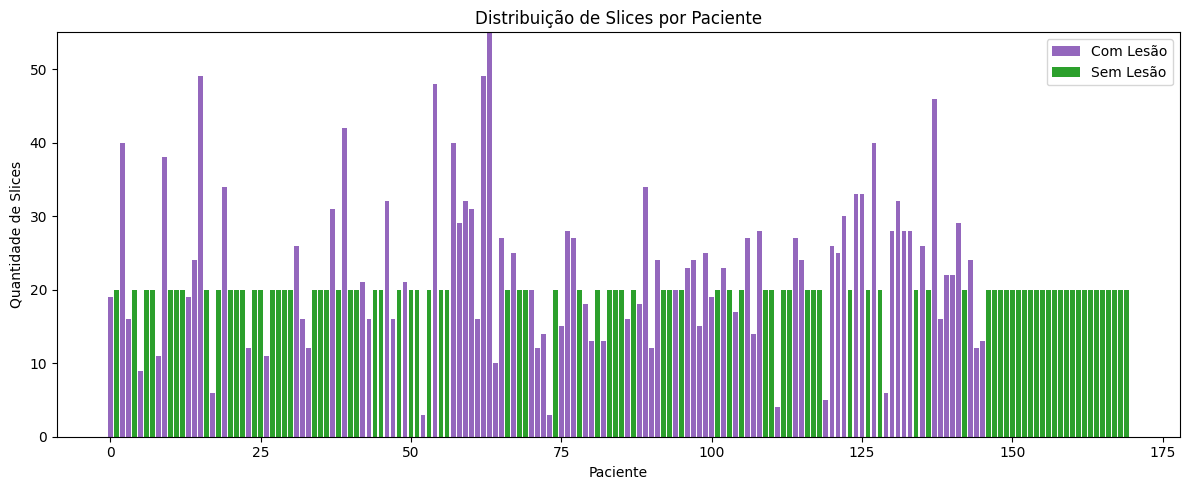

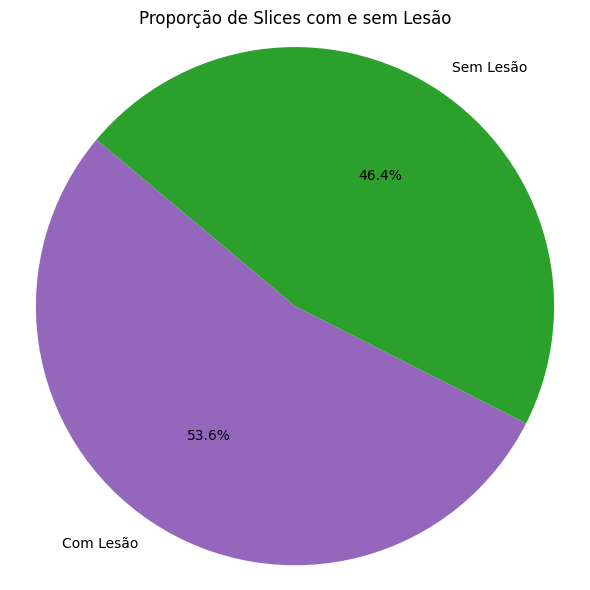

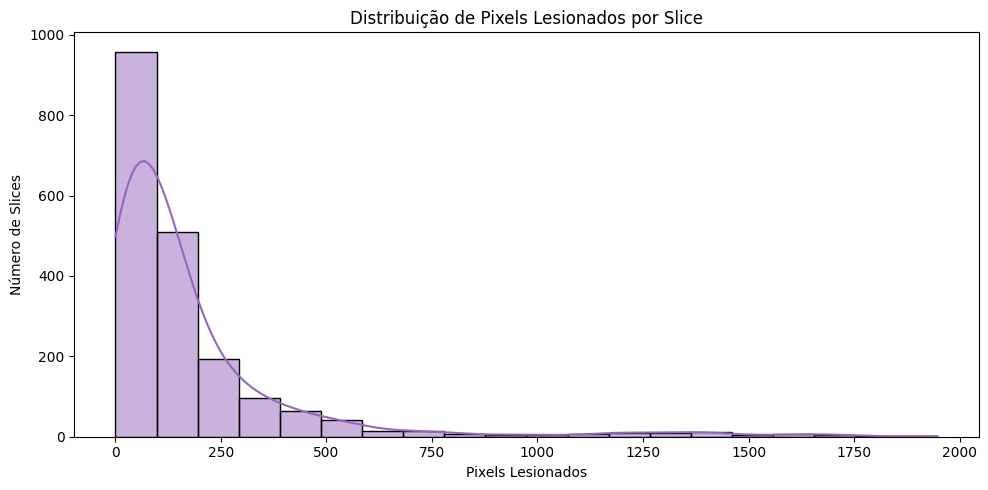

In [ ]:
# Imports necessários
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio

# Caminho base do dataset
base_dir = "/content/drive/MyDrive/TCC/slices_subs"

# Inicializa listas
slices_por_paciente = []
slices_com_lesao = []
slices_sem_lesao = []
pixel_lesionados_por_slice = []

# Percorre pacientes
for paciente in sorted(os.listdir(base_dir)):
    paciente_path = os.path.join(base_dir, paciente)
    flair_dir = os.path.join(paciente_path, "flair")
    mask_dir = os.path.join(paciente_path, "mask")

    if not os.path.isdir(flair_dir):
        continue

    # Conta número total de slices FLAIR
    flair_slices = len([f for f in os.listdir(flair_dir) if f.endswith(".png")])
    slices_por_paciente.append(flair_slices)

    # Máscaras
    if os.path.exists(mask_dir):
        mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith(".png")])
        slices_com_lesao.append(len(mask_files))
        slices_sem_lesao.append(flair_slices - len(mask_files))

        # Conta pixels lesionados por slice
        for mask_file in mask_files:
            mask_path = os.path.join(mask_dir, mask_file)
            mask = imageio.imread(mask_path)

            if mask.ndim == 3:
                mask = mask[..., 0]  # se RGB, pega canal único

            pixel_lesionados_por_slice.append(np.sum(mask == 255))
    else:
        slices_com_lesao.append(0)
        slices_sem_lesao.append(flair_slices)

# GRÁFICO 1: Slices por paciente
plt.figure(figsize=(12, 5))
plt.bar(range(len(slices_por_paciente)), slices_com_lesao, label='Com Lesão', color='tab:purple')
plt.bar(range(len(slices_por_paciente)), slices_sem_lesao, bottom=slices_com_lesao, label='Sem Lesão', color='tab:green')
plt.xlabel("Paciente")
plt.ylabel("Quantidade de Slices")
plt.title("Distribuição de Slices por Paciente")
plt.legend()
plt.tight_layout()
plt.show()

# GRÁFICO 2: Proporção de slices
total_com_lesao = sum(slices_com_lesao)
total_sem_lesao = sum(slices_sem_lesao)

plt.figure(figsize=(6, 6))
plt.pie([total_com_lesao, total_sem_lesao],
        labels=["Com Lesão", "Sem Lesão"],
        autopct='%1.1f%%',
        colors=['tab:purple', 'tab:green'],
        startangle=140)
plt.title("Proporção de Slices com e sem Lesão")
plt.axis('equal')
plt.tight_layout()
plt.show()

# GRÁFICO 3: Histograma de pixels lesionados
if pixel_lesionados_por_slice:
    plt.figure(figsize=(10, 5))
    sns.histplot(pixel_lesionados_por_slice, bins=20, kde=True, color='tab:purple')
    plt.title("Distribuição de Pixels Lesionados por Slice")
    plt.xlabel("Pixels Lesionados")
    plt.ylabel("Número de Slices")
    plt.tight_layout()
    plt.show()